# Dependencies

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Data Cleaning

In [2]:
# reading into raw csv data
filepath = "Resources/crypto_data.csv"
df = pd.read_csv(filepath)
df.head()

,Unnamed: 0,CoinName,Algorithm,IsTrading,ProofType,TotalCoinsMined,TotalCoinSupply
0,42,42 Coin,Scrypt,True,PoW/PoS,4.199995e+01,42
1,365,365Coin,X11,True,PoW/PoS,NaN,2300000000
2,404,404Coin,Scrypt,True,PoW/PoS,1.055185e+09,532000000
3,611,SixEleven,SHA-256,True,PoW,NaN,611000
4,808,808,SHA-256,True,PoW/PoS,0.000000e+00,0


In [3]:
# clean col names
df.rename(columns={'Unnamed: 0':'Key'}, inplace=True)

# filtering out inactive coins and dropping unnecessary col
row_count = len(df.index)
df = df.loc[df['IsTrading']]
df.drop('IsTrading', axis=1, inplace=True)
print(f"Drop inactive coin: was {row_count} rows, dropped {row_count - len(df.index)}, now {len(df.index)}")
row_count = len(df.index)

# drop na values
df.dropna(inplace=True)
print(f"Drop null: was {row_count} rows, dropped {row_count - len(df.index)}, now {len(df.index)}")
row_count = len(df.index)

# filtering only the coins that have over 0 mined
df = df.loc[df['TotalCoinsMined'] > 0]
print(f"Drop unmined coins: was {row_count} rows, dropped {row_count - len(df.index)}, now {len(df.index)}")

# keeping only numeric data
df.drop(['Key', 'CoinName'], axis=1, inplace=True)

# clean up data types
df = df.astype({'TotalCoinSupply': 'float'})
print(df.dtypes)
print('-----')

Drop inactive coin: was 1252 rows, dropped 108, now 1144
Drop null: was 1144 rows, dropped 459, now 685
Drop unmined coins: was 685 rows, dropped 153, now 532
Algorithm           object
ProofType           object
TotalCoinsMined    float64
TotalCoinSupply    float64
dtype: object
-----


# ML Model Wrangling

In [4]:
# one-hot encoding
col_count = len(df.columns)
X_dummies = pd.get_dummies(df)
print(f"One-hot encoding: was {col_count}, added {len(X_dummies.columns) - col_count}, now {len(X_dummies.columns)}")
col_count = len(X_dummies.columns)
X_dummies.head()

One-hot encoding: was 4, added 94, now 98


,TotalCoinsMined,TotalCoinSupply,Algorithm_1GB AES Pattern Search,Algorithm_536,Algorithm_Argon2d,Algorithm_BLAKE256,Algorithm_Blake,Algorithm_Blake2S,Algorithm_Blake2b,Algorithm_C11,...,ProofType_PoW/PoS,ProofType_PoW/PoS,ProofType_PoW/PoW,ProofType_PoW/nPoS,ProofType_Pos,ProofType_Proof of Authority,ProofType_Proof of Trust,ProofType_TPoS,ProofType_Zero-Knowledge Proof,ProofType_dPoW/PoW
0,4.199995e+01,4.200000e+01,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,1.055185e+09,5.320000e+08,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
5,2.927942e+10,3.141593e+11,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
7,1.792718e+07,2.100000e+07,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,1.076842e+08,0.000000e+00,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
# standardizing the scale, assuming data is normal and thus standard scale would be a better fit for model
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_dummies)

# feature reduction
pca = PCA(n_components=0.9, random_state = 42)
X_reduced = pca.fit_transform(X_scaled)
print(f"PCA reduction: was {col_count}, dropped {col_count - X_reduced.shape[1]}, now {X_reduced.shape[1]}")
col_count = X_reduced.shape[1]

PCA reduction: was 98, dropped 24, now 74


TSNE reduction shape (532, 2)
tSNE: was 74 dropped 72, now 2
Vaugely the shape of 2 clusters with some outliers.


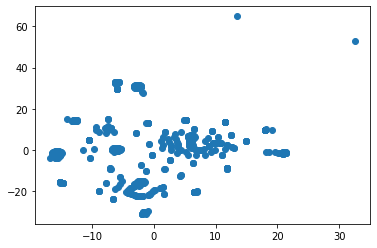

In [6]:
# reduce more + visualizing with tsne
tsne = TSNE(learning_rate=35, random_state = 42)
X_tsne = tsne.fit_transform(X_reduced)
print(f'TSNE reduction shape {X_tsne.shape}')
print(f'tSNE: was {col_count} dropped {col_count - X_tsne.shape[1]}, now {X_tsne.shape[1]}')

plt.scatter(X_tsne[:,0], X_tsne[:,1])
print(f'Vaugely the shape of 3 clusters with many outliers.')

# ML Analysis

C:\Users\Chrismus Time\anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


Text(0, 0.5, 'Inertia')

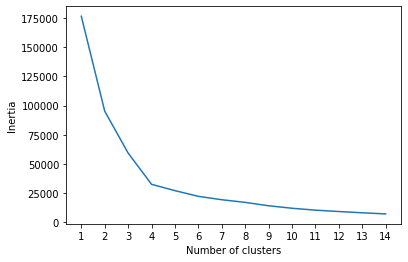

In [7]:
# k-Means model analysis to determine best number of clusters
max_num = 15
inertia = []
k = list(range(1, max_num))

# loop through for best k
for i in k:
    km = KMeans(n_clusters = i, random_state = 42)
    km.fit(X_tsne)
    inertia.append(km.inertia_)

# formatting results into df
elbow_data = {"k": k, "inertia": inertia}
df_elbow = pd.DataFrame(elbow_data)

plt.plot(df_elbow['k'], df_elbow['inertia'])
plt.xticks(range(1,max_num))
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

In [9]:
print(f'Ultimately, it looks like k at 4 is the best fit number of clusters to classify our data. We can reapply the PCA model knowing that 4 clusters is our goal.')

Ultimately, it looks like k at 4 is the best fit number of clusters to classify our data. We can reapply the PCA model knowing that 4 clusters is our goal.


Ultimately, it looks like k at 4 is the best fit number of clusters to classify our data.
PCA reduction: was 74, dropped 70, now 4
TSNE reduction shape (532, 2)
tSNE: was 4 dropped 2, now 2


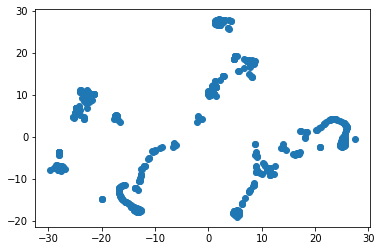

In [8]:
# feature reduction
pca = PCA(n_components=4, random_state = 42)
X_reduced = pca.fit_transform(X_scaled)
print(f"PCA reduction: was {col_count}, dropped {col_count - X_reduced.shape[1]}, now {X_reduced.shape[1]}")
col_count = X_reduced.shape[1]

# reduce more + visualizing with tsne
tsne = TSNE(learning_rate=35, random_state = 42)
X_tsne = tsne.fit_transform(X_reduced)
print(f'TSNE reduction shape {X_tsne.shape}')
print(f'tSNE: was {col_count} dropped {col_count - X_tsne.shape[1]}, now {X_tsne.shape[1]}')

plt.scatter(X_tsne[:,0], X_tsne[:,1])

In [ ]:
print(f'Model, while still messy, is much more clearly defined in this visualization. Thus, there are 4 main clusters we can package cryptocurrencies into.')